In [6]:
# Imports - exercise 6
import math
from skimage import color, io, measure, img_as_ubyte
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import img_as_ubyte
from skimage.util import img_as_float
import time
import cv2
from scipy.ndimage import correlate
from skimage.filters import median
from skimage.filters import prewitt_h
from skimage.filters import prewitt_v
from skimage.filters import prewitt
from skimage.filters import gaussian
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk 
from skimage import color
from skimage.util import img_as_ubyte
from skimage.util import img_as_float
from skimage.filters import prewitt
from skimage.filters import threshold_otsu
from skimage.filters import median
from skimage.filters import gaussian
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb

from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance

In [7]:
def plot_comparison(original, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()

In [3]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


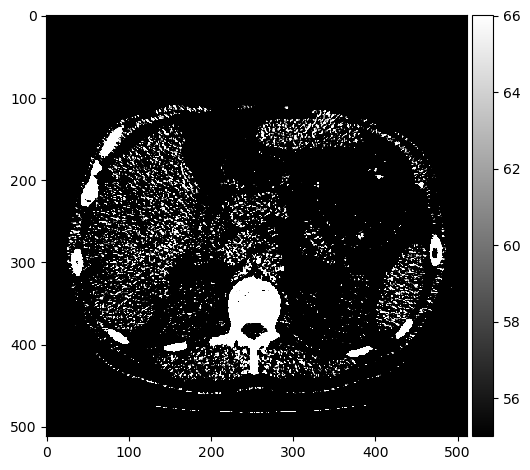

In [8]:
# Exercise 1
io.imshow(img, vmin=55, vmax=66, cmap='gray')
io.show()


In [14]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

print(spleen_values.max(), spleen_values.min(), np.median(spleen_values))

99 -3 49.0


In [19]:
# Exercise 2
std_spleen = np.std(spleen_values)
mu_spleen = np.mean(spleen_values)
print(np.std(spleen_values), np.mean(spleen_values))

14.9970794143059 49.48026905829597


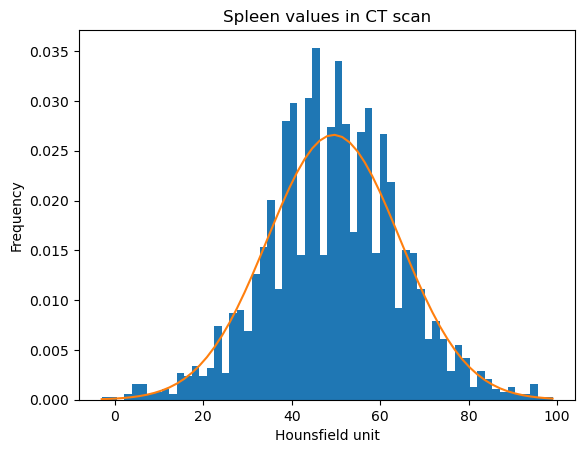

In [21]:
# Exercise 3
n, bins, patches = plt.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

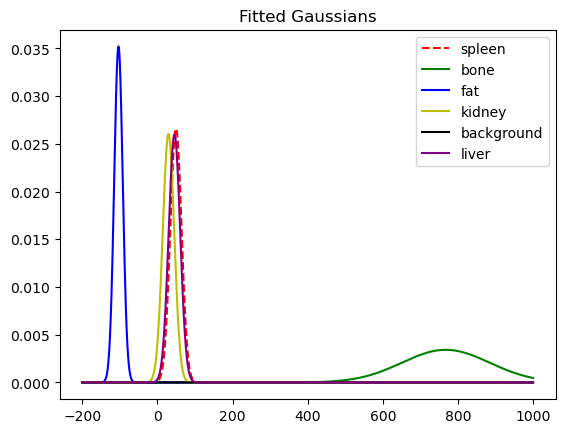

In [32]:
# Exercise 4
# Bone 
bone_roi = io.imread(in_dir + 'BoneROI.png')
# convert to boolean image
bone_mask = bone_roi > 0
bone_values = img[bone_mask]

std_bone = np.std(bone_values)
mu_bone = np.mean(bone_values)

# Fat
fat_roi = io.imread(in_dir + 'FatROI.png')
# convert to boolean image
fat_mask = fat_roi > 0
fat_values = img[fat_mask]

std_fat = np.std(fat_values)
mu_fat = np.mean(fat_values)

# Kindey
kidney_roi = io.imread(in_dir + 'KidneyROI.png')
# convert to boolean image
kidney_mask = kidney_roi > 0
kidney_values = img[kidney_mask]

std_kidney = np.std(kidney_values)
mu_kidney = np.mean(kidney_values)

# Liver
liver_roi = io.imread(in_dir + 'LiverROI.png')
# convert to boolean image
liver_mask = liver_roi > 0
liver_values = img[liver_mask]

std_liver = np.std(liver_values)
mu_liver = np.mean(liver_values)

# Background
background_roi = io.imread(in_dir + 'BackgroundROI.png')
# convert to boolean image
background_mask = background_roi > 0
background_values = img[background_mask]

std_background = np.std(background_values)
mu_background = np.mean(background_values)



# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)
pdf_kidney = norm.pdf(hu_range, mu_kidney, std_kidney)
pdf_background = norm.pdf(hu_range, mu_background, std_background)
pdf_liver = norm.pdf(hu_range, mu_liver, std_liver)

plt.plot(hu_range, pdf_spleen, 'r--', label="spleen")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.plot(hu_range, pdf_fat, 'b', label="fat")
plt.plot(hu_range, pdf_kidney, 'y', label="kidney")
plt.plot(hu_range, pdf_background, 'black', label="background")
plt.plot(hu_range, pdf_liver, 'purple', label="liver")

plt.title("Fitted Gaussians")
plt.legend()
plt.show()

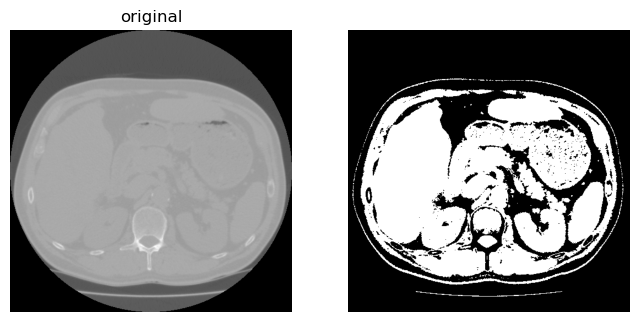

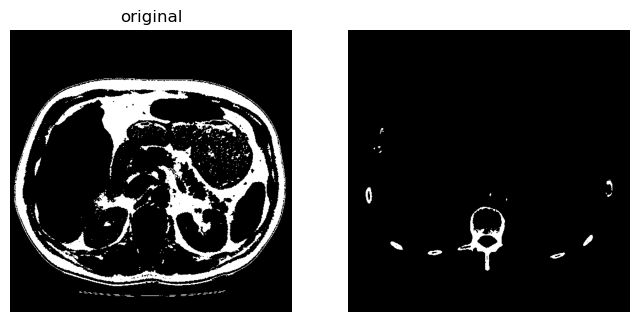

In [53]:
# Exercise 7
t_background = -200
t_fat_soft = -20
t_soft_bone = 200


fat_img = (img > t_background) & (img <= t_fat_soft)
bone_img = (img > t_soft_bone) & (img <= 2000)
soft_img = (img > t_fat_soft) & (img < t_soft_bone)

plot_comparison(img, soft_img, "")
plot_comparison(fat_img, bone_img, "")

In [59]:
# compute mean ogf soft tissue class 
soft_tissue_values = np.append(kidney_values, spleen_values)
soft_tissue_values = np.append(soft_tissue_values, liver_values)
(mu_soft, std_soft) = norm.fit(soft_tissue_values)

# compute thresholds 
t_background = -200
t_fat_soft = (mu_fat + mu_soft) / 2.0
t_soft_bone = (mu_soft + mu_bone) / 2.0 

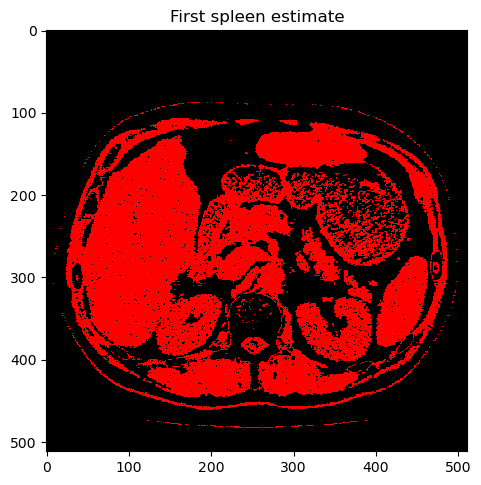

In [101]:
# Exercise 11
t_1 = 10
t_2 = 90

spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

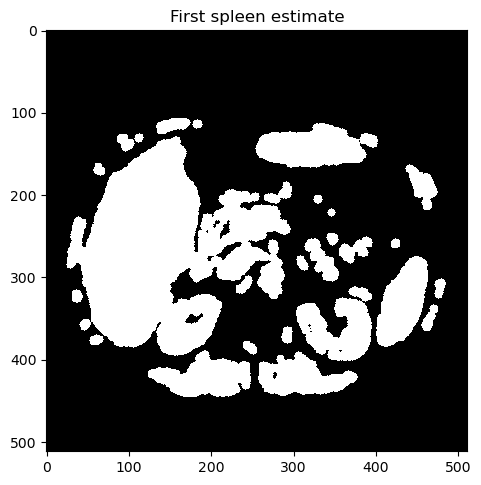

In [114]:
footprint = disk(1)
closed = binary_closing(spleen_estimate, footprint)

footprint = disk(5)
opened = binary_opening(closed, footprint)

io.imshow(opened)
plt.title("First spleen estimate")
io.show()

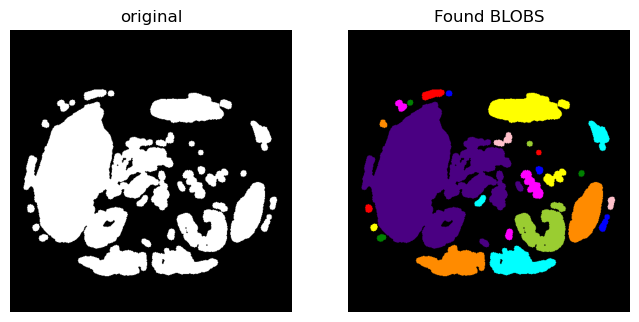

In [118]:
# Exercise 12
label_img = measure.label(opened)
image_label_overlay = label2rgb(label_img)
plot_comparison(opened, image_label_overlay, 'Found BLOBS')

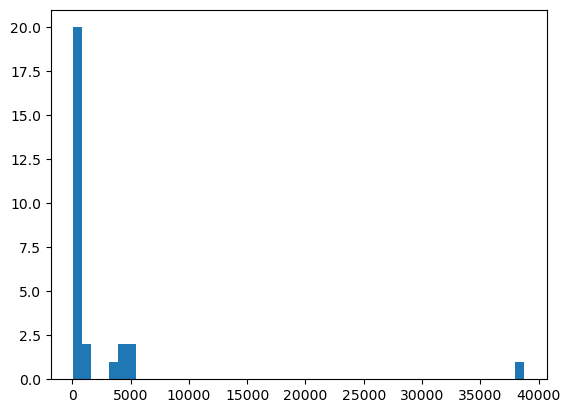

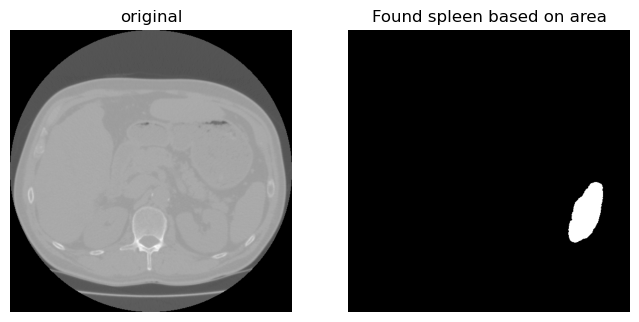

In [137]:
# Exercise 13
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])

plt.hist(areas, bins=50)
plt.show()

min_area = 4400
max_area = 4500

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.area > max_area or region.area < min_area:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
plot_comparison(img, i_area, 'Found spleen based on area')

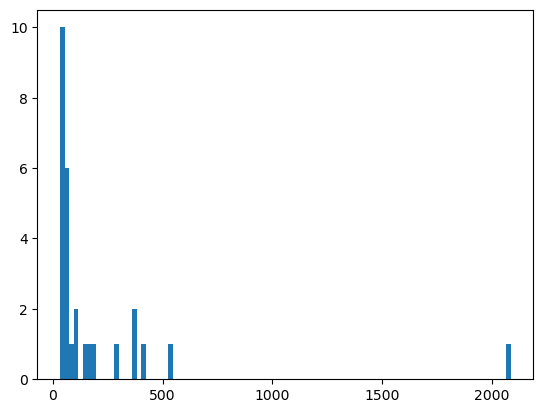

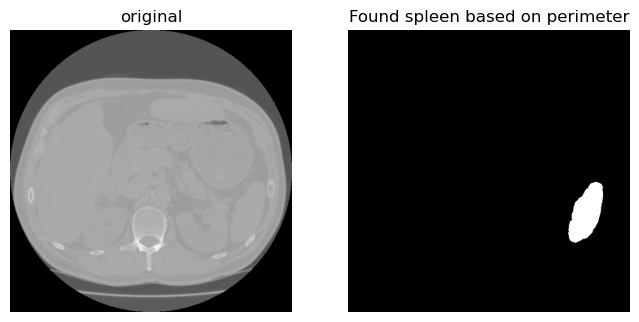

In [154]:
perimeters = np.array([prop.perimeter for prop in region_props])
plt.hist(perimeters, bins=100)
plt.show()

min_perimeter = 200
max_perimeter = 300

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.perimeter > max_perimeter or region.perimeter < min_perimeter:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
plot_comparison(img, i_area, 'Found spleen based on perimeter')


In [220]:
def spleen_finder(img):
    # Estimation
    t_1 = 20
    t_2 = 80

    spleen_estimate = (img > t_1) & (img < t_2)
    spleen_label_colour = color.label2rgb(spleen_estimate)
    
    
    # Fill
    footprint = disk(2)
    closed = binary_closing(spleen_estimate, footprint)

    footprint = disk(4)
    opened = binary_opening(closed, footprint)
    
    # BLOB analysis
    label_img = measure.label(opened)
    image_label_overlay = label2rgb(label_img)
    
    # Areas
    region_props = measure.regionprops(label_img)
    areas = np.array([prop.area for prop in region_props])
    
    min_area = 1000
    max_area = 10000
    
    # Perimeters
    perimeters = np.array([prop.perimeter for prop in region_props])

    min_perimeter = 250
    max_perimeter = 350
    
    # Excentricity
    eccentricity = np.array([prop.eccentricity for prop in region_props])

    min_eccentricity = 0.9
    
    # Create a copy of the label_img
    label_img_filter = label_img.copy()
    for region in region_props:
        # Find the areas that do not fit our criteria
        if (region.area > max_area or region.area < min_area) or (region.perimeter > max_perimeter or region.perimeter < min_perimeter) or (region.eccentricity < min_eccentricity):
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    # Create binary image from the filtered label image
    i_area = label_img_filter > 0

    return i_area

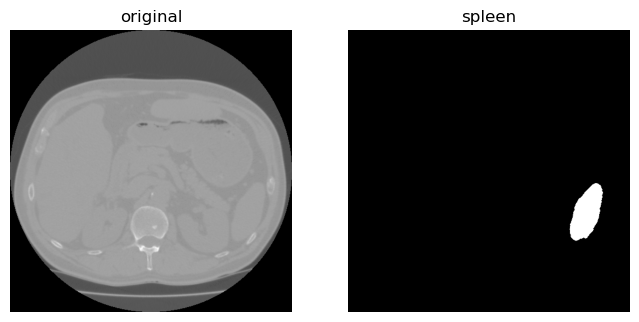

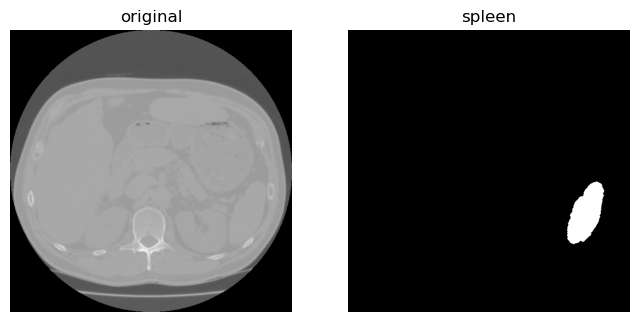

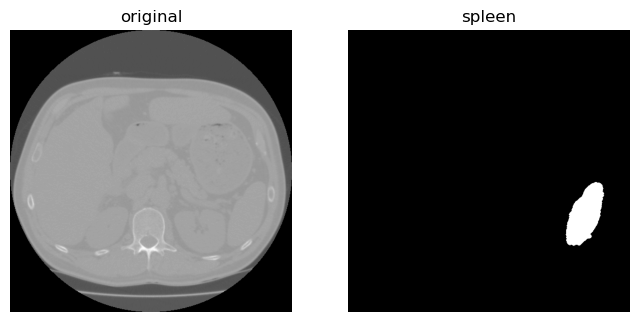

In [225]:
ct = dicom.read_file(in_dir + 'Validation1.dcm')
img_val1 = ct.pixel_array

val1 = spleen_finder(img_val1)
plot_comparison(img_val1, val1, "spleen")

ct = dicom.read_file(in_dir + 'Validation2.dcm')
img_val2 = ct.pixel_array

val2 = spleen_finder(img_val2)
plot_comparison(img_val2, val2, "spleen")

ct = dicom.read_file(in_dir + 'Validation3.dcm')
img_val3 = ct.pixel_array

val3 = spleen_finder(img_val3)
plot_comparison(img_val3, val3, "spleen")

In [228]:
ground_truth_img = io.imread(in_dir + 'Validation1_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(spleen_finder(img_val1).ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

ground_truth_img = io.imread(in_dir + 'Validation2_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(spleen_finder(img_val2).ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

ground_truth_img = io.imread(in_dir + 'Validation3_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(spleen_finder(img_val3).ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.9558359621451105
DICE score 0.9620925717788904
DICE score 0.9715459078908771
